# Bayesian parameter estimation

This notebook applies the Markov Chain Monte Carlo (MCMC) algorithm to compute posterior distributions for estimated wall decay coefficients.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
import scipy.stats as stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import random
from pyDOE import lhs
from bayesian_wq_calibration.epanet import build_model, sensor_model_id, epanet_simulator, set_reaction_parameters
from bayesian_wq_calibration.mcmc import decision_variables_to_dict
from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
from bayesian_wq_calibration.data import bulk_temp_adjust

### Load data

Load operational data for selected sensing period.

In [3]:
data_period = 18 # 21 calibration events (as at 31 October 2024)
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
except:
    print(f"Data period {data_period} does not exist.")

Surrogate model data period.

In [5]:
surrogate_days = 2

n_total = len(flow_df['datetime'].unique())
n_surrogate = surrogate_days * 24 * 4
surrogate_range = range(n_surrogate)
surrogate_datetime = flow_df['datetime'].unique()[list(surrogate_range)]
total_range = range(n_total)
total_datetime = flow_df['datetime'].unique()[list(total_range)]

Bulk decay.

In [6]:
bulk_coeff = -0.85 # day^-1 (from bottle tests)
field_temp = wq_df[wq_df['data_type'] == 'temperature']['mean'].mean()
bulk_coeff = bulk_temp_adjust(bulk_coeff, field_temp)

Wall decay grouping.

In [7]:
grouping = 'material-velocity' # 'single', 'material', 'material-diameter', 'material-velocity'

if grouping == 'single':
    param_bounds = [(-1.0, 0.0)] # single wall decay coefficient
elif grouping == 'material':
    param_bounds = [(-1.0, 0.0), (-0.25, 0.0), (-0.1, 0.0)] # variable order: metallic, cement, plastic_unknown
elif grouping == 'material-diameter':
    param_bounds = [(-1.0, 0.0), (-0.5, 0.0), (-0.25, 0.0), (-0.1, 0.0)] # variable order: metallic_less_than_150, metallic_greater_than_150, cement, plastic_unknown
elif grouping == 'material-velocity':
    param_bounds = [(-1.0, 0.0), (-0.5, 0.0), (-0.5, 0.0), (-0.25, 0.0), (-0.25, 0.0), (-0.1, 0.0)] # variable order: metallic_low_velocity, metallic_high_velocity, cement_low_velocity, cement_high_velocity, plastic_low_velocity, plastic_high_velocity

wall_params = [random.uniform(lower, upper) for lower, upper in param_bounds]
n_params = len(wall_params)

### Create surrogate model
This notebook will create the following surrogate models of EPANET's water quality simulator:
- Gaussian process regression
- Recurrent neural network
- Polynomial chaos expansion

**EPANET simulator**

Build water model using `wntr`.

In [8]:
demand_resolution = 'wwmd'
wn = build_model(flow_df[flow_df['datetime'].isin(surrogate_datetime)], pressure_df[pressure_df['datetime'].isin(surrogate_datetime)], cl_df[cl_df['datetime'].isin(surrogate_datetime)], sim_type='chlorine', demand_resolution=demand_resolution, bulk_coeff=bulk_coeff)

Get mean velocities (for 'material-velocity' grouping).

In [9]:
if grouping == 'material-velocity':
    sim_results = epanet_simulator(wn, 'velocity', cl_df[cl_df['datetime'].isin(surrogate_datetime)])
    vel_sim = sim_results.velocity.T
    mean_vel = vel_sim.mean(axis=1)
    mean_vel = mean_vel.reset_index().rename(columns={'name': 'link_id', 0: 'mean_vel'})
else:
    mean_vel = None

Define simualtor function.

In [17]:
def simulator(cl_df, wall_params, wn, grouping, mean_vel):
    wall_params = decision_variables_to_dict(grouping, wall_params)
    _wn = set_reaction_parameters(wn, grouping, wall_params, None, mean_vel)
    
    sim_type = 'chlorine'
    sim_results = epanet_simulator(_wn, sim_type, cl_df)
    cl_sim = sim_results.chlorine
    
    sensor_data = sensor_model_id('wq')
    cl_sim = cl_sim[sensor_data['model_id'].unique()]
    name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
    cl_sim = cl_sim.rename(columns=name_mapping)

    cl_sim = cl_sim.T
    cl_sim.columns = [f't_{idx+1}' for idx in range(cl_sim.shape[1])]

    cl_sim = cl_sim.drop(index=['BW1', 'BW4'], errors='ignore') # remove inlet sensors
    
    return cl_sim

In [18]:
cl_simulator = simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], wall_params, wn, grouping, mean_vel)

**Design of experiments**

Latin Hypercube Sampling (LHS)

In [108]:
n_samples = 100

def experiments_lhs(param_bounds, n_params, n_samples):
    samples = lhs(n_params, samples=n_samples)
    scaled_samples = np.array([
        low + (high - low) * sample
        for (low, high), sample in zip(param_bounds, samples.T)
    ]).T
    return scaled_samples

In [109]:
param_experiments = experiments_lhs(param_bounds, n_params, n_samples)

**Gausian process model**

Create train and test data from experimental sampling.

In [110]:
n_train = 80

X_train = param_experiments[:n_train]
Y_train = np.array([
    simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], params, wn, grouping, mean_vel)
    for params in X_train
])

X_test = param_experiments[n_train:]
Y_test = np.array([
    simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], params, wn, grouping, mean_vel)
    for params in X_test
])

In [111]:
Y_train_flat = Y_train.reshape(n_train, Y_train.shape[1] * Y_train.shape[2]) # reshape for GP model
# Y_pred = Y_train_flat.reshape(n_samples, Y_train.shape[1], Y_train.shape[2])

Train Guassian process model.

In [112]:
kernel = C(1.0, (1e-5, 1e5)) * RBF(1.0, (1e-5, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, Y_train_flat)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=50, normalize_y=True)

Also test:
- Squared exponential
- Gamma expontential
- Matern
- Rational quadratic

Test model performance.

In [123]:
Y_pred_flat = gp.predict(X_test)
Y_pred = Y_pred_flat.reshape(n_samples-n_train, Y_train.shape[1], Y_train.shape[2])
Y_test_flat = Y_test.reshape(n_samples-n_train, Y_train.shape[1] * Y_train.shape[2])
Y_test_flat.shape

(20, 1344)

Mean Squared Error: 2.1380646189862587e-05
Mean Absolute Error: 0.002067534498441165
Maximum Absolute Error: 0.038375788346036555


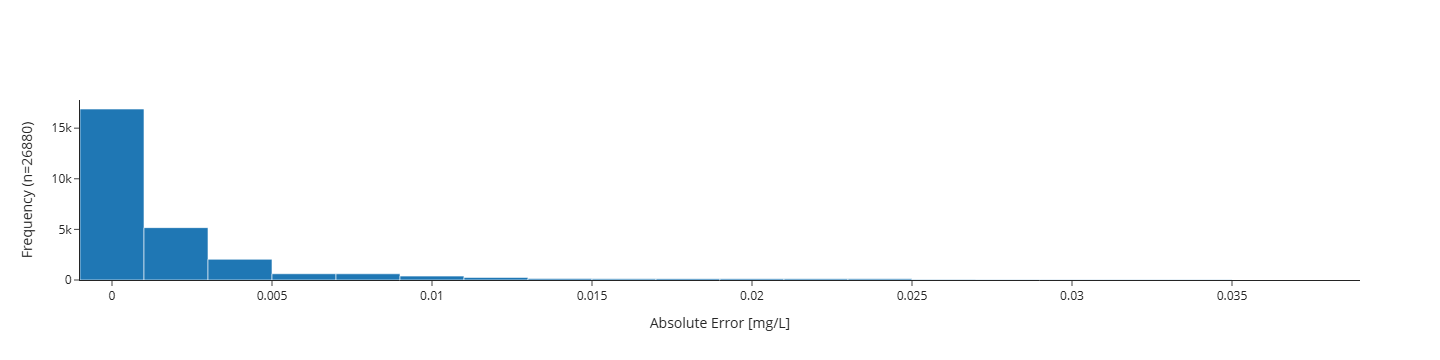

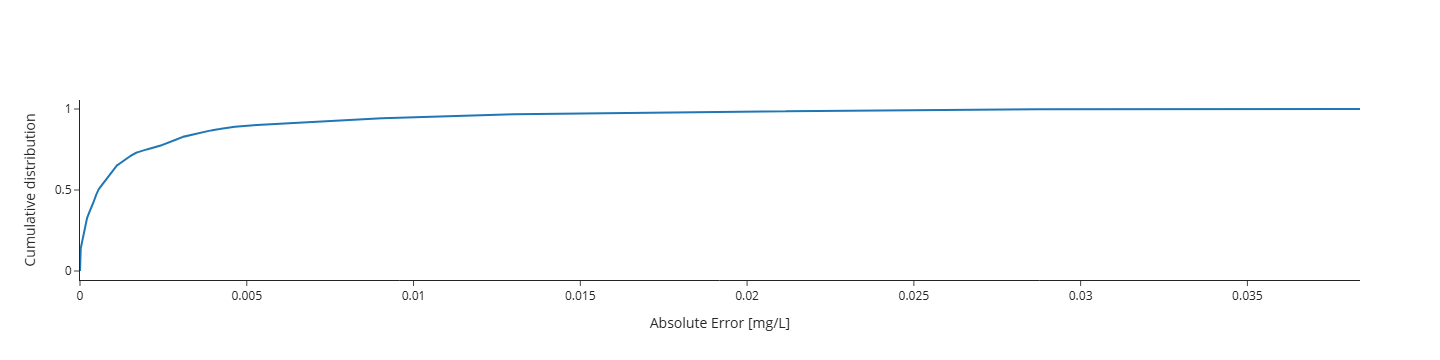

In [131]:
# performance metrics
mse = np.mean((Y_test_flat - Y_pred_flat) ** 2)
print(f"Mean Squared Error: {mse}")
mae = np.mean(np.abs(Y_test_flat - Y_pred_flat))
print(f"Mean Absolute Error: {mae}")
maxae = np.max(np.abs(Y_test_flat - Y_pred_flat))
print(f"Maximum Absolute Error: {maxae}")

# histogram plot
absolute_errors = np.abs(Y_test_flat - Y_pred_flat).flatten()
fig = go.Figure(data=[go.Histogram(x=absolute_errors, nbinsx=25)])
fig.update_layout(
    xaxis_title="Absolute Error [mg/L]",
    yaxis_title=f"Frequency (n={len(absolute_errors)})",
    template="simple_white",
    width=600
)
fig.show()

# cdf plot
sorted_errors = np.sort(absolute_errors)
cdf_values = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sorted_errors,
    y=cdf_values,
    mode='lines',
))
fig.update_layout(
    xaxis_title="Absolute Error [mg/L]",
    yaxis_title="Cumulative distribution",
    template="simple_white",
    width=600
)
fig.show()

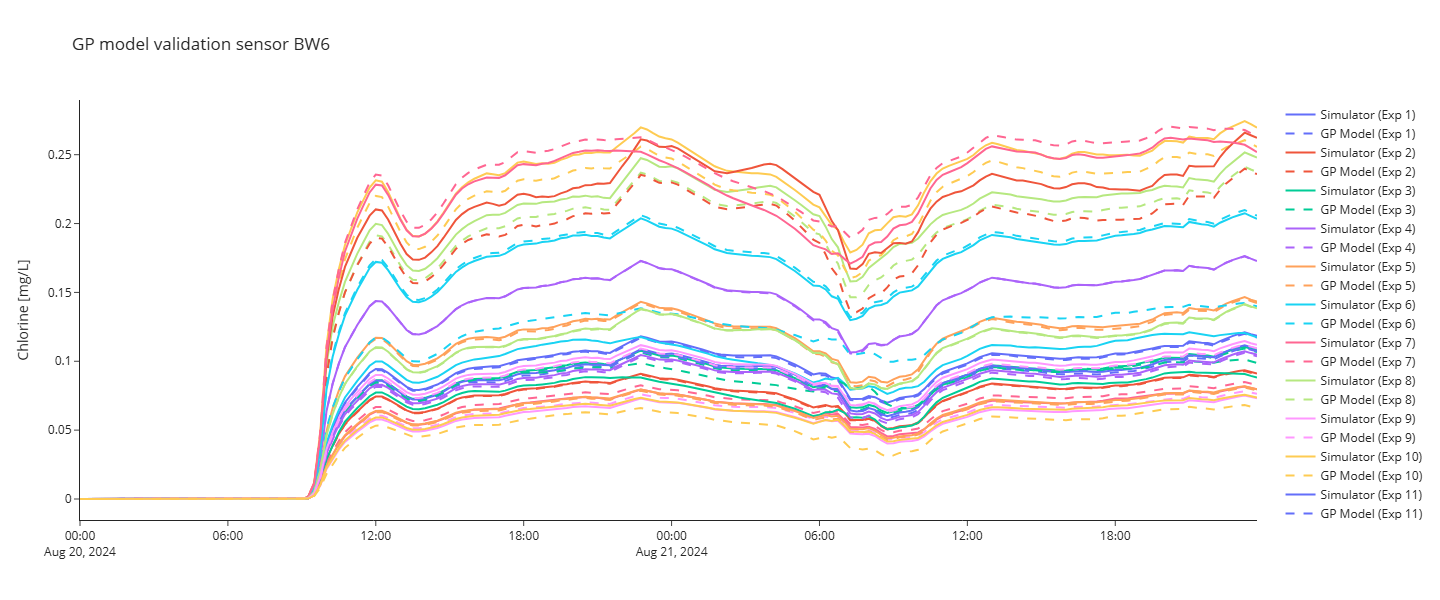

In [115]:
selected_sensor_idx = 3
sensor_name = cl_simulator.index[selected_sensor_idx]

fig = go.Figure()

actual_data = Y_test[:, selected_sensor_idx, :]
predicted_data = Y_pred[:, selected_sensor_idx, :]

for exp_idx in range(n_samples-n_train):
    color = default_colors[exp_idx % len(default_colors)]
    fig.add_trace(
        go.Scatter(
            x=surrogate_datetime,
            y=actual_data[exp_idx, :],
            mode='lines',
            name=f"Simulator (Exp {exp_idx + 1})",
            line=dict(color=color, dash='solid'),
            showlegend=True
        )
    )
    fig.add_trace(
        go.Scatter(
            x=surrogate_datetime,
            y=predicted_data[exp_idx, :],
            mode='lines',
            name=f"GP Model (Exp {exp_idx + 1})",
            line=dict(color=color, dash='dash'),
            showlegend=True
        )
    )
fig.update_yaxes(
    title_text="Chlorine [mg/L]",
    rangemode="tozero"
)
fig.update_layout(
    height=600,  # Fixed height since there's only one plot
    template='simple_white',
    legend_title_text='',
    title=f"GP model validation sensor {sensor_name}"
)
fig.show()

### Define loglikelihood score function

In [ ]:
# def loglikelihood(sim, cl_df):
    
#     sensor_data = sensor_model_id('wq')
#     bwfl_ids = [sensor for sensor in sensor_data['bwfl_id'].unique() if sensor not in ['BW1', 'BW4']]
#     datetime = cl_df['datetime'].unique()[96:]
    
#     loglikelihood = 0
#     for name in bwfl_ids:   
#         _sim = sim[name].values
#         data = cl_df.loc[cl_df['bwfl_id'] == name, 'mean'].values
#         mask = ~np.isnan(sim) & ~np.isnan(data) & (np.arange(len(sim)) >= 96)
#         mse += (1 / (len(datetime) * len(bwfl_ids))) * np.sum((sim[mask] - data[mask]) ** 2)
    
#     return None